<a href="https://colab.research.google.com/github/Tom-McDonald/studynotebooks/blob/master/Chapter_8_Exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chapter 8 - Dimensionality Reduction
---

* **1. What are the main motivations for reducing a dataset’s dimensionality? What are the main drawbacks?**
> The main motivation for dimensionality reduction is reducing training time, as a dataset with reduced dimensionality will inherently contain less data points due to the reduced number of features. Another common reason for reducing dimensionality is for visualising datasets with high dimensionality in 2-D or 3-D (via t-SNE for example), or just to reduce file size. The primary drawback is that during the dimensionality process, information is always lost, and typically this will result in a reduction in model accuracy (although this is not always the case, as dimensionality reduction may remove noise in some cases, improving accuracy). Another issue is that the process can be computationally heavy and the output is in most cases, very hard to interpret, so whilst models using reduced dimensionality may train faster, they likely won't be as explainable as say, a Random Forest on the original dataset where the feature importances are easily accessible and interpretable.

* **2. What is the curse of dimensionality?**
> It is the fact that in high dimensional space, instances of data are highly likely to be close to a border, typically resulting in large distances between instances. This makes models based on highly dimensional data more prone to overfitting as the model will find it harder to generalise given the sparse nature of the data.

* **3. Once a dataset’s dimensionality has been reduced, is it possible to reverse the operation? If so, how? If not, why?**
> It is possible to reverse the operation to an extent, through a process called *reconstruction*. For PCA for example, you can simply invert the transformation and retain what is left of the original data as some of the information will have been lost; the extent to which this is true depends on how much variance was lost during the compression. Some other dimensionality reduction methods such as t-SNE have no means for reversing the transformation.

* **4. Can PCA be used to reduce the dimensionality of a highly nonlinear dataset?**
> Yes, PCA can generally be used in this instance as it will discard dimensions which don't contribute much in terms of variance; an example of this would be the third dimension in a 3-D dataset consisting of points scattered across a 2-D plane. However, if all the dimensions in a dataset are important, PCA is not the best choice as too much useful information will be discarded.

* **5. Suppose you perform PCA on a 1,000-dimensional dataset, setting the explained variance ratio to 95%. How many dimensions will the resulting dataset have?**
> There's no general case answer for this as it depends on the dataset. The dataset will have a number *n* dimensions,  where *n* is equal to the number of principal components which are required to account for 95% of the variance of the original data, with the components sorted such that the largest explained variances are counted first.

* **6. In what cases would you use vanilla PCA, Incremental PCA, Randomized PCA, or Kernel PCA?**
> Vanilla PCA `(or kernel='linear')` can be effective but only if the data fits in memory. Incremental PCA fits in small chunks and is therefore best suited to extremely large datasets which won't fit on disk, or alternatively online learning problems where new data is continuously streaming in, however it is slower than vanilla. Randomized PCA stochastically finds an approximation of the principal components and is best suited for situations where the data fits on disk and the desired dimensionality $d<<n$, the original dimensionality, due to to the fact that it's computational complexity scales as $O(m*d^2) + O(d^3)$ as opposed to $O(m*n^2) + O(n^3)$ for vanilla PCA; it is much faster than vanilla PCA under these circumstances. Kernel PCA is also used for data which can fit on desk and is a very robust method that is useful when working with nonlinear data as it performs well in terms of preserving clusters of instances after projection. 

* **7. How can you evaluate the performance of a dimensionality reduction algorithm on your dataset?**
> There are two main ways to approach this. The simpler method is to create a pipeline including a dimensionality reduction algorithm followed by an estimator, and then perform a gridsearch on the hyperparameters of the dimensionality reduction algorithm, selecting the hyperparameters which maximise the performance of the estimator. An alternative process which only uses the dimensionality reduction algorithm involves transforming the data, reconstructing it, and then measuring the *reconstruction error* which is the MSE between the reconstructed data and the original data; a good implementation of dimensionality reduction should minimise this error as if the reconstructed data differs little from the original then it means that little information/variance has been lost in the process. 

* **8. Does it make any sense to chain two different dimensionality reduction algorithms?**
> In some situations it can make sense to chain two different algorithms together, especially in the situation where each handles different tasks well. PCA is well suited to swiftly removing useless information from a dataset so chaining this with a more nuanced manifold learning technique would be a good approach for dimensionality reduction of a relatively nonlinear dataset with a number of useless dimensions.

* **9. Load the MNIST dataset (introduced in Chapter 3) and split it into a training set and a test set (take the first 60,000 instances for training, and the remaining 10,000 for testing). Train a Random Forest classifier on the dataset and time how long it takes, then evaluate the resulting model on the test set. Next, use PCA to reduce the dataset’s dimensionality, with an explained variance ratio of 95%. Train a new Random Forest classifier on the reduced dataset and see how long it takes. Was training much faster? Next evaluate the classifier on the test set: how does it compare to the previous classifier?**

> As usual, our first step is to load in the MNIST dataset and separate the training and test sets.

In [2]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

np.random.seed(42)                                                               # makes notebook output reproducible across runs

def sort_by_target(mnist):                                                       # function is required as 'fetch_openml returns' the unsorted MNIST data
    reorder_train = np.array(sorted([(target, i) for i, target in \
                                     enumerate(mnist.target[:60000])]))[:, 1]    # 'sort_by_target' makes the dataset the same as is used in the book
    reorder_test = np.array(sorted([(target, i) for i, target in  \
                                     enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]
    
mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8)                                      # fetch_openml() returns targets as strings
sort_by_target(mnist)                                                            # fetch_openml() returns an unsorted dataset

X, y = mnist["data"], mnist["target"]
print('Shape of MNIST data: ', X.shape)
print('Shape of MNIST target data: ', y.shape)

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

Shape of MNIST data:  (70000, 784)
Shape of MNIST target data:  (70000,)


Firstly, we train a Random Forest Classifier on the original data and evaluate it on the test set. With 20 trees and 2 CPU cores, this cell takes ~8 seconds to execute.

In [3]:
%%time
rfc = RandomForestClassifier(n_estimators=20, n_jobs=-1)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print('Accuracy of RFC on original data:', accuracy_score(y_test, y_pred))

Accuracy of RFC on original data: 0.9602
CPU times: user 16.5 s, sys: 20.6 ms, total: 16.5 s
Wall time: 8.56 s


Now, we use PCA to reduce the dimensionality of the data, specifying an explained variance of 95%.

In [0]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_train_dim = pca.fit_transform(X_train)
X_test_dim = pca.transform(X_test)

> Following this, we repeat the training and evaluation process from before, but instead use the tranformed dataset with lower dimensionality. Contrary to what might be expected, this cell takes ~16s to execute, twice as long as the original data took. The exercise solutions note that this shows that dimensionality reduction isn't a guaranteed way to speed up training; a softmax regression model for example would have experienced a x4 reduction in training time for this same reduction in dimensionality, so practically, how useful these methods can be depends very much on the type of estimator and the dataset. As expected due to the lost information, the accuracy of the model is lower on the transformed training data.


In [5]:
%%time
rfc.fit(X_train_dim, y_train)
y_pred = rfc.predict(X_test_dim)
print('Accuracy of RFC on reduced dimensionality data:', 
      accuracy_score(y_test, y_pred))

Accuracy of RFC on reduced dimensionality data: 0.9242
CPU times: user 31.8 s, sys: 86.6 ms, total: 31.9 s
Wall time: 16.5 s


* **10. Use t-SNE to reduce the MNIST dataset down to two dimensions and plot the result using Matplotlib. You can use a scatterplot using 10 different colors to represent each image’s target class. Alternatively, you can write colored digits at the location of each instance, or even plot scaled-down versions of the digit images themselves (if you plot all digits, the visualization will be too cluttered, so you should either draw a random sample or plot an instance only if no other instance has already been plotted at a close distance). You should get a nice visualization with well-separated clusters of digits. Try using other dimensionality reduction algorithms such as PCA, LLE, or MDS and compare the resulting visualizations.**

> t-SNE on all 60,000 images takes a very long time, so we'll use a 5,000 image subset of the data for this exercise. The resulting visualisation clusters the digits very nicely, whilst there is some overlap present corresponding to the digits which are often mistaken for one another, most of the digits sit in very distinct groups that are easy to pick out.

In [0]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=123)
X_sample, y_sample = X_train[:5000], y_train[:5000]
X_tsne = tsne.fit_transform(X_sample)

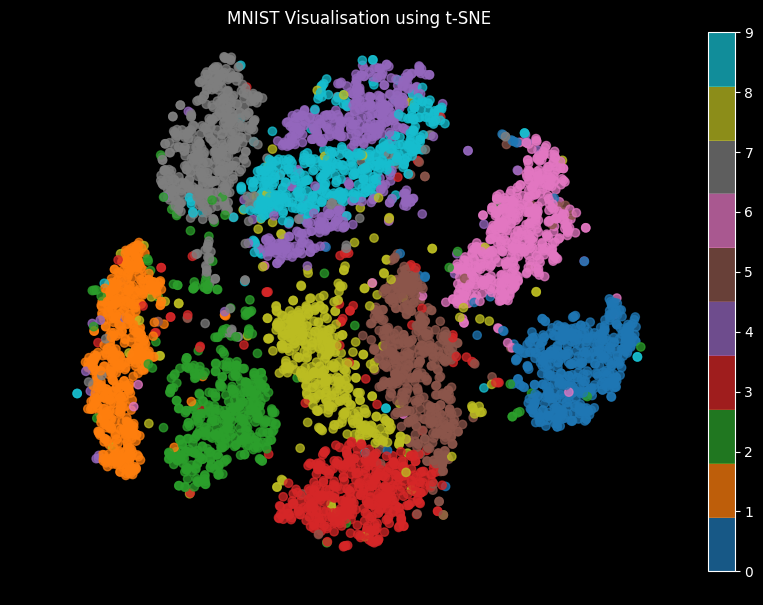

In [21]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

plt.figure(figsize=(10, 7))
plt.title('MNIST Visualisation using t-SNE')
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_sample, cmap='tab10', alpha=0.75)
plt.colorbar()
plt.axis('off')
plt.show()

PCA by comparison executes this block of code almost instantly, so is much faster than t-SNE, but also we cannot see the same defined clusters as before; there is far too much overlap for this to be a useful visualisation.

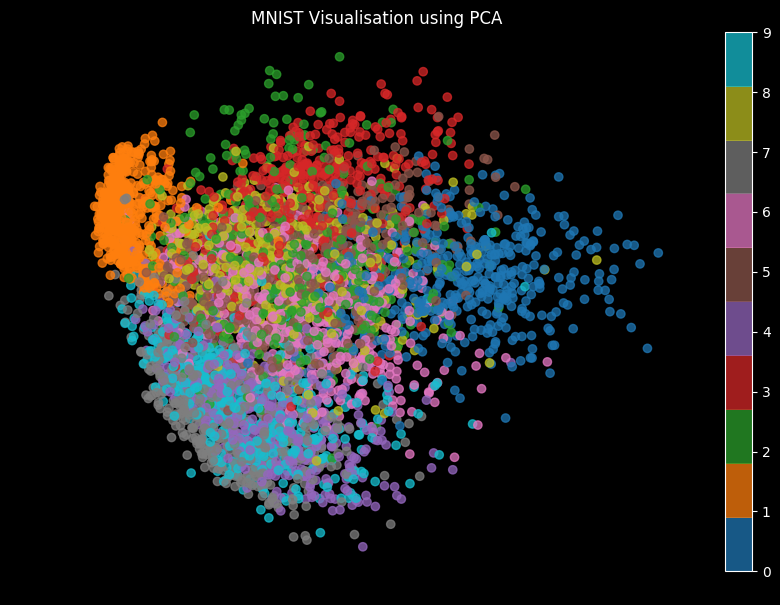

In [23]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sample)

plt.figure(figsize=(10, 7))
plt.title('MNIST Visualisation using PCA')
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_sample, cmap='tab10', alpha=0.75)
plt.colorbar()
plt.axis('off')
plt.show()

Checking this against the exercise solutions, other methods such as LDA, LLE and MDS all underperform compared to t-SNE, much in the way PCA does.

The ideal trade-off between speed and quality of output would be to use PCA with an explained variance of ~95% and then use the output of this with t-SNE.